<a href="https://colab.research.google.com/github/ATSQLITE/MIE1623--A2/blob/main/2_Assessing_seasonality_trend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# If statsmodels isn't installed in your Colab runtime, run:
!pip -q install statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

# Load data
# define path
PATH = "/content/cleaned_A2.xlsx"

df = pd.read_excel(PATH)

print(df.shape)
display(df.head())
print(df.columns)


(2135, 10)


,Patient,Delivery Date,Day of Week,Delivery Time,CS type,OR Arrival Time,OR Departure Time,Total Patient OR time,Adjusted Total Patient OR time,Delivery_DateTime
0,1,2013-04-01,Monday,01:21:00,Unplanned,2013-04-01 00:46:35.000,2013-04-01 03:51:24.000,184,0.127778,2013-04-01 01:21:00
1,3,2013-04-01,Monday,11:23:00,Planned-not as sched,2013-04-01 10:36:50.623,2013-04-01 12:01:40.623,84,0.058333,2013-04-01 11:23:00
2,4,2013-04-01,Monday,12:33:00,Unplanned,2013-04-01 11:47:01.307,2013-04-01 13:05:30.307,78,0.054167,2013-04-01 12:33:00
3,5,2013-04-01,Monday,16:37:00,Unplanned,2013-04-01 16:20:29.167,2013-04-01 17:30:20.167,69,0.047917,2013-04-01 16:37:00
4,6,2013-04-02,Tuesday,08:28:00,Planned-as scheduled,2013-04-02 07:53:40.260,2013-04-02 09:19:08.260,85,0.059028,2013-04-02 08:28:00


Index(['Patient', 'Delivery Date', 'Day of Week', 'Delivery Time', 'CS type',
       'OR Arrival Time', 'OR Departure Time', 'Total Patient OR time',
       'Adjusted Total Patient OR time', 'Delivery_DateTime'],
      dtype='object')


In [2]:
# Make sure these columns are datetime
dt_cols = ["OR Arrival Time", "OR Departure Time", "Delivery_DateTime", "Delivery Date"]
for c in dt_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# If Delivery_DateTime doesn't exist, build it from date + time
if "Delivery_DateTime" not in df.columns and ("Delivery Date" in df.columns and "Delivery Time" in df.columns):
    df["Delivery_DateTime"] = pd.to_datetime(
        df["Delivery Date"].dt.date.astype(str) + " " + df["Delivery Time"].astype(str),
        errors="coerce"
    )

# Convenience series: daily counts
daily_deliveries = df.dropna(subset=["Delivery_DateTime"]).set_index("Delivery_DateTime").resample("D").size()
daily_arrivals   = df.dropna(subset=["OR Arrival Time"]).set_index("OR Arrival Time").resample("D").size()
daily_departures = df.dropna(subset=["OR Departure Time"]).set_index("OR Departure Time").resample("D").size()

print("Daily series lengths:", len(daily_deliveries), len(daily_arrivals), len(daily_departures))
display(pd.DataFrame({
    "deliveries": daily_deliveries.head(),
    "arrivals": daily_arrivals.head(),
    "departures": daily_departures.head()
}))


Daily series lengths: 365 365 365


,deliveries,arrivals,departures
2013-04-01,4,4,4
2013-04-02,6,6,6
2013-04-03,9,10,9
2013-04-04,6,5,5
2013-04-05,6,6,7


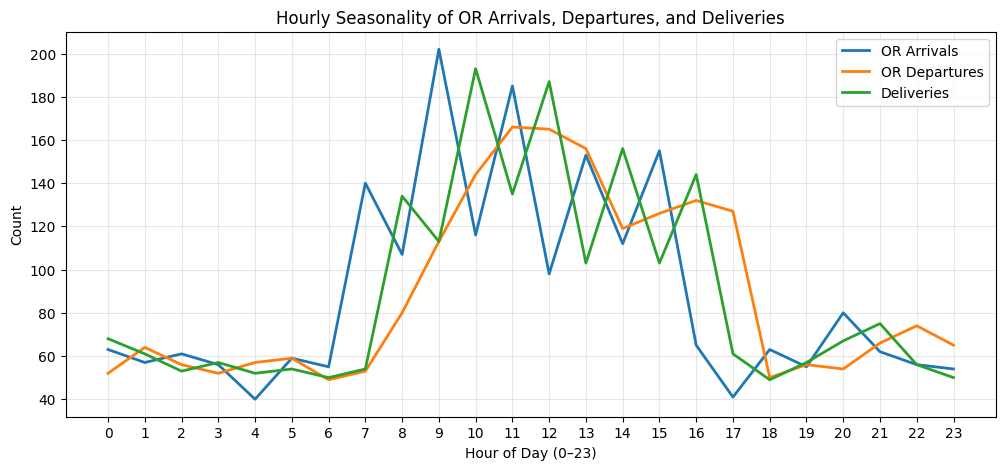

In [3]:
# Build hourly counts for each series
def hourly_counts(datetime_series):
    s = datetime_series.dropna()
    hours = s.dt.hour
    counts = hours.value_counts().sort_index()
    return counts.reindex(range(24), fill_value=0)

hour_arrivals   = hourly_counts(df["OR Arrival Time"])
hour_departures = hourly_counts(df["OR Departure Time"])
hour_deliveries = hourly_counts(df["Delivery_DateTime"])

# Plot all three on one graph
plt.figure(figsize=(12,5))

plt.plot(hour_arrivals.index, hour_arrivals.values, label="OR Arrivals", linewidth=2)
plt.plot(hour_departures.index, hour_departures.values, label="OR Departures", linewidth=2)
plt.plot(hour_deliveries.index, hour_deliveries.values, label="Deliveries", linewidth=2)

plt.xticks(range(0,24))
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Count")
plt.title("Hourly Seasonality of OR Arrivals, Departures, and Deliveries")
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()

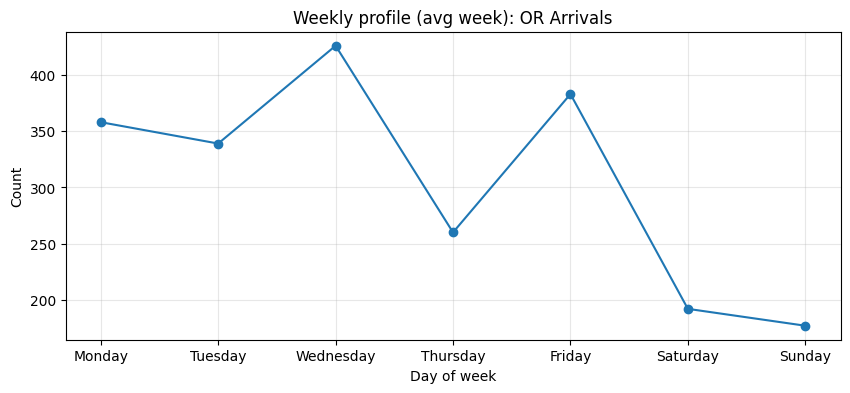

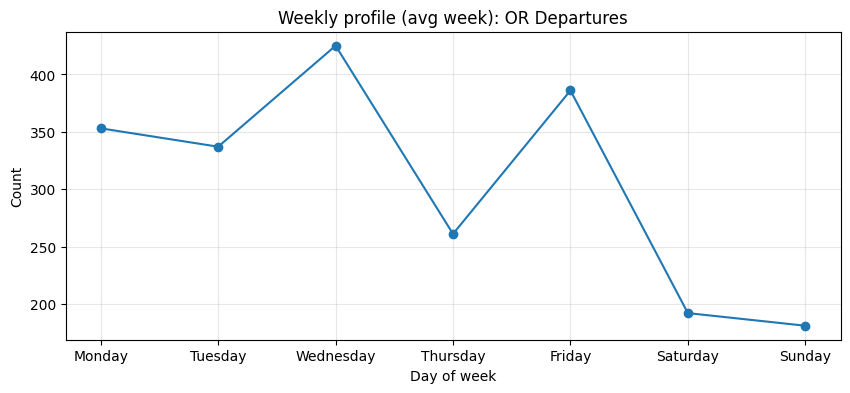

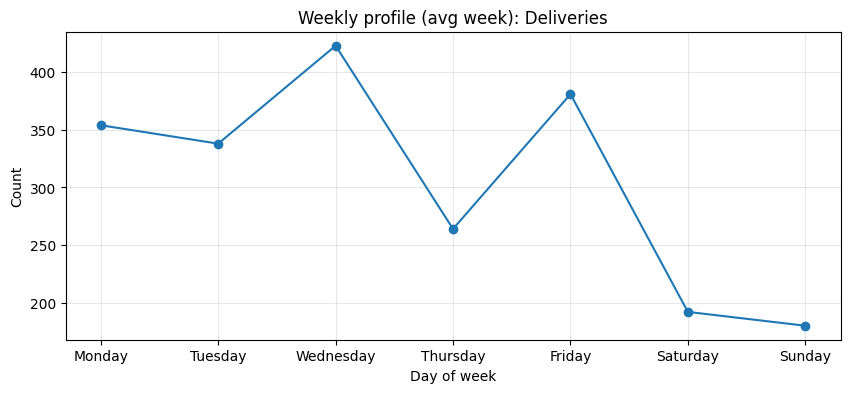

In [4]:
def dayname_order():
    return ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

def weekly_profile(datetime_series, title):
    s = datetime_series.dropna()
    day = s.dt.day_name()
    counts = day.value_counts()
    counts = counts.reindex(dayname_order(), fill_value=0)

    plt.figure(figsize=(10,4))
    plt.plot(counts.index, counts.values, marker="o")
    plt.xlabel("Day of week")
    plt.ylabel("Count")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

weekly_profile(df["OR Arrival Time"],   "Weekly profile (avg week): OR Arrivals")
weekly_profile(df["OR Departure Time"], "Weekly profile (avg week): OR Departures")
weekly_profile(df["Delivery_DateTime"], "Weekly profile (avg week): Deliveries")


<Figure size 1000x400 with 0 Axes>

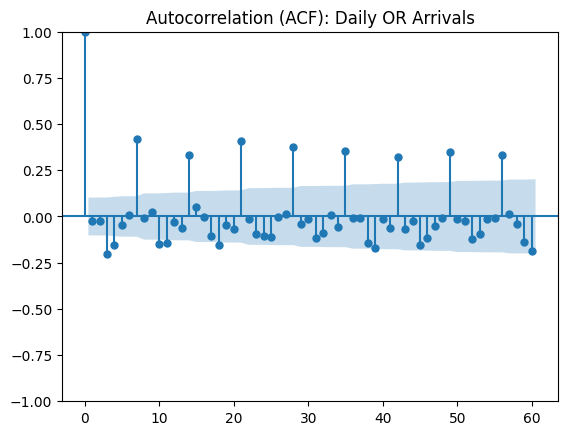

In [5]:
series = daily_arrivals.asfreq("D").fillna(0)

plt.figure(figsize=(10,4))
plot_acf(series, lags=60)  # ~2 months of lags
plt.title("Autocorrelation (ACF): Daily OR Arrivals")
plt.show()


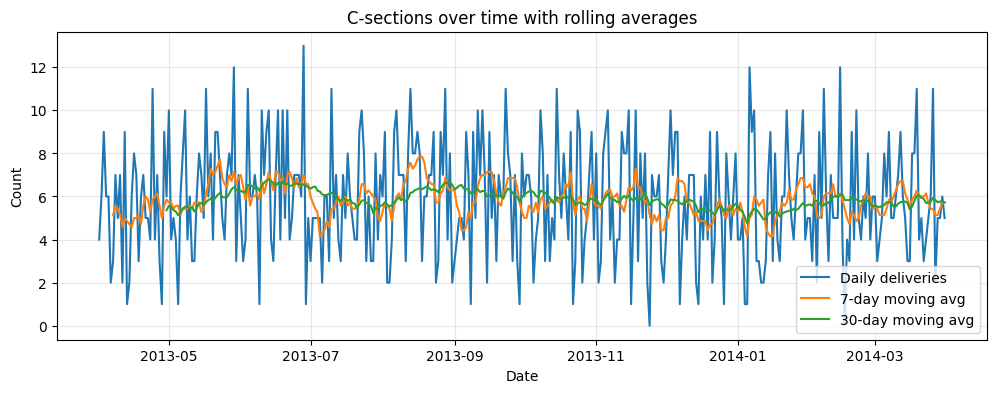

In [6]:
cs_daily = daily_deliveries.asfreq("D").fillna(0)

roll7 = cs_daily.rolling(7).mean()
roll30 = cs_daily.rolling(30).mean()

plt.figure(figsize=(12,4))
plt.plot(cs_daily.index, cs_daily.values, label="Daily deliveries")
plt.plot(roll7.index, roll7.values, label="7-day moving avg")
plt.plot(roll30.index, roll30.values, label="30-day moving avg")
plt.title("C-sections over time with rolling averages")
plt.xlabel("Date")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


In [7]:
def adf_report(x, name="series"):
    x = pd.Series(x).dropna()
    result = adfuller(x, autolag="AIC")
    stat, pvalue, usedlag, nobs, crit, icbest = result

    print(f"ADF test on {name}")
    print(f"  Test statistic: {stat:.4f}")   # 4 decimals
    print(f"  p-value:        {pvalue:.6f}") # 6 decimals
    print(f"  used lag:       {usedlag}")
    print(f"  nobs:           {nobs}")      # of observations
    for k,v in crit.items():
        print(f"  critical value ({k}): {v:.4f}")
    print(f"  autolag criterion (AIC best): {icbest:.4f}")

adf_report(cs_daily, "daily deliveries (C-sections)")
adf_report(series, "daily OR arrivals")


ADF test on daily deliveries (C-sections)
  Test statistic: -4.7014
  p-value:        0.000084
  used lag:       13
  nobs:           351
  critical value (1%): -3.4491
  critical value (5%): -2.8698
  critical value (10%): -2.5712
  autolag criterion (AIC best): 1597.4128
ADF test on daily OR arrivals
  Test statistic: -4.6907
  p-value:        0.000088
  used lag:       13
  nobs:           351
  critical value (1%): -3.4491
  critical value (5%): -2.8698
  critical value (10%): -2.5712
  autolag criterion (AIC best): 1593.0093


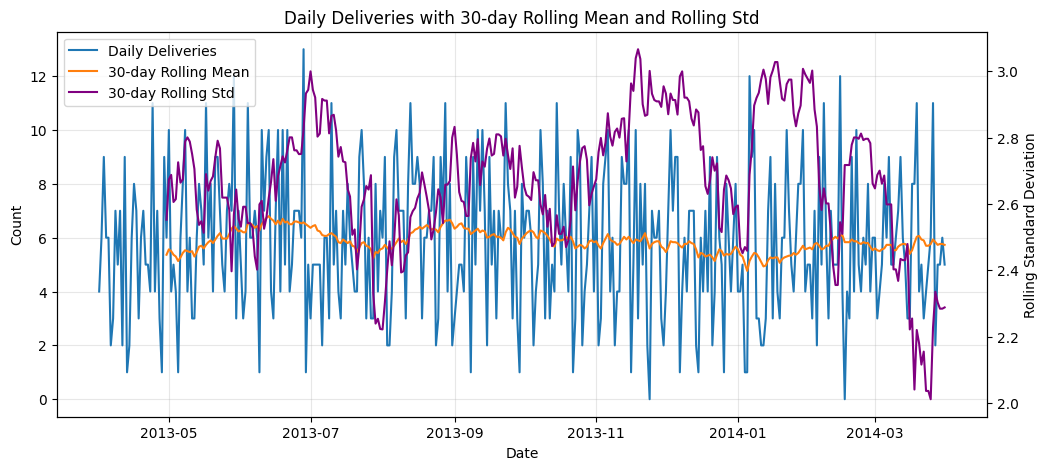

In [8]:
# 30-day rolling meand and std
roll_mean_30 = cs_daily.rolling(30).mean()
roll_std_30  = cs_daily.rolling(30).std()

fig, ax1 = plt.subplots(figsize=(12,5))

# Original series + rolling mean
ax1.plot(cs_daily.index, cs_daily.values, label="Daily Deliveries")
ax1.plot(roll_mean_30.index, roll_mean_30.values, label="30-day Rolling Mean")

ax1.set_xlabel("Date")
ax1.set_ylabel("Count")
ax1.grid(True, alpha=0.3)

# Secondary axis for rolling std
ax2 = ax1.twinx()
ax2.plot(roll_std_30.index, roll_std_30.values,
         color="purple",
         label="30-day Rolling Std")

ax2.set_ylabel("Rolling Standard Deviation")

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

plt.title("Daily Deliveries with 30-day Rolling Mean and Rolling Std")
plt.show()


In [9]:
DT_COL = "Delivery_DateTime"
TYPE_COL = "CS type"

# Ensure correct data types
df[DT_COL] = pd.to_datetime(df[DT_COL], errors="coerce")
df[TYPE_COL] = df[TYPE_COL].astype(str).str.strip().str.lower()

# Define Planned vs Unplanned
is_planned = df[TYPE_COL].isin(["planned-as scheduled", "planned-not as sched"])
is_unplanned = df[TYPE_COL].str.startswith("unplanned", na=False)

# Add weekday column
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
df["weekday"] = df[DT_COL].dt.day_name()

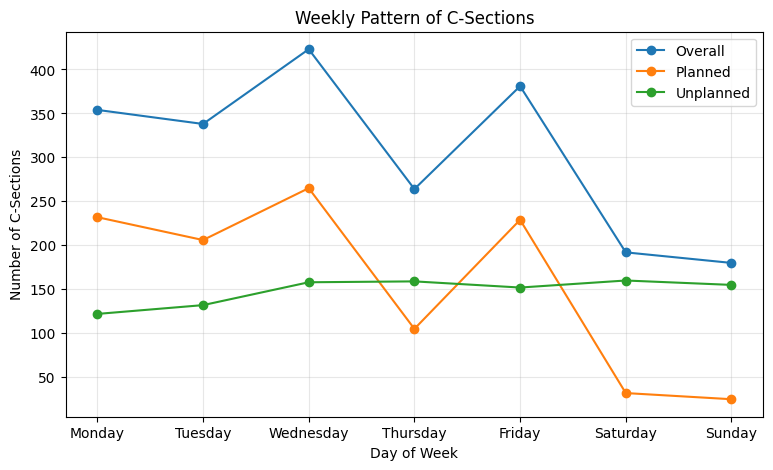

In [10]:
def weekly_counts(sub_df):
    return (
        sub_df.dropna(subset=[DT_COL])
              .groupby("weekday")
              .size()
              .reindex(weekday_order, fill_value=0)
    )

wk_overall   = weekly_counts(df)
wk_planned   = weekly_counts(df[is_planned])
wk_unplanned = weekly_counts(df[is_unplanned])

plt.figure(figsize=(9,5))
plt.plot(wk_overall.index, wk_overall.values, marker="o", label="Overall")
plt.plot(wk_planned.index, wk_planned.values, marker="o", label="Planned")
plt.plot(wk_unplanned.index, wk_unplanned.values, marker="o", label="Unplanned")

plt.title("Weekly Pattern of C-Sections")
plt.xlabel("Day of Week")
plt.ylabel("Number of C-Sections")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


<Figure size 800x400 with 0 Axes>

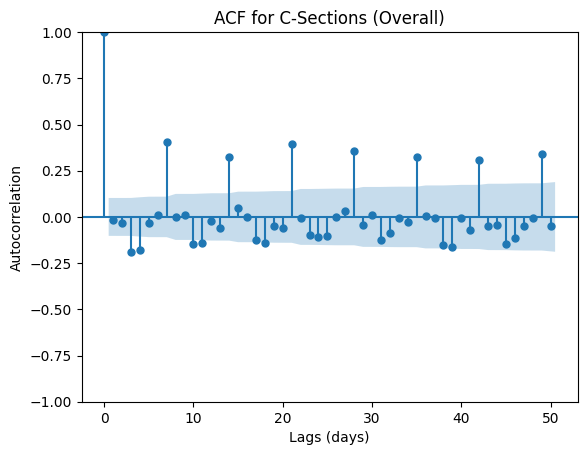

<Figure size 800x400 with 0 Axes>

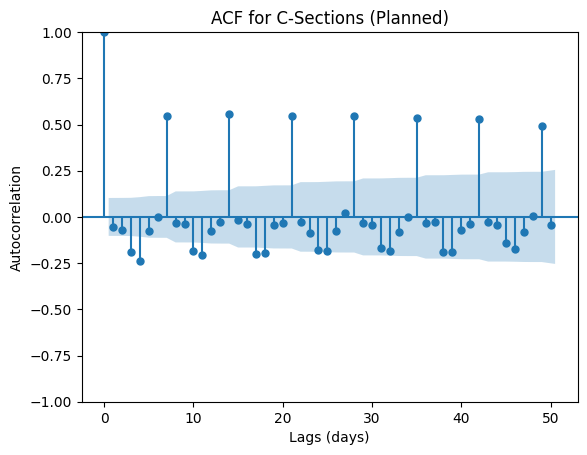

<Figure size 800x400 with 0 Axes>

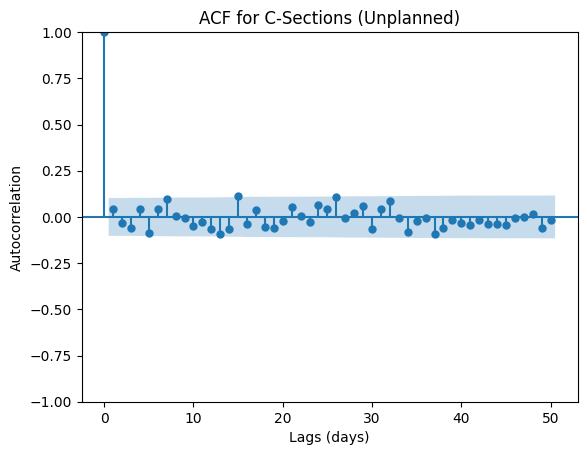

In [11]:
def daily_series(sub_df):
    return (
        sub_df.dropna(subset=[DT_COL])
              .set_index(DT_COL)
              .resample("D")
              .size()
              .asfreq("D")
              .fillna(0)
    )

ts_overall   = daily_series(df)
ts_planned   = daily_series(df[is_planned])
ts_unplanned = daily_series(df[is_unplanned])

# Overall ACF
plt.figure(figsize=(8,4))
plot_acf(ts_overall, lags=50)
plt.title("ACF for C-Sections (Overall)")
plt.xlabel("Lags (days)")
plt.ylabel("Autocorrelation")
plt.show()

# Planned ACF
plt.figure(figsize=(8,4))
plot_acf(ts_planned, lags=50)
plt.title("ACF for C-Sections (Planned)")
plt.xlabel("Lags (days)")
plt.ylabel("Autocorrelation")
plt.show()

# Unplanned ACF
plt.figure(figsize=(8,4))
plot_acf(ts_unplanned, lags=50)
plt.title("ACF for C-Sections (Unplanned)")
plt.xlabel("Lags (days)")
plt.ylabel("Autocorrelation")
plt.show()


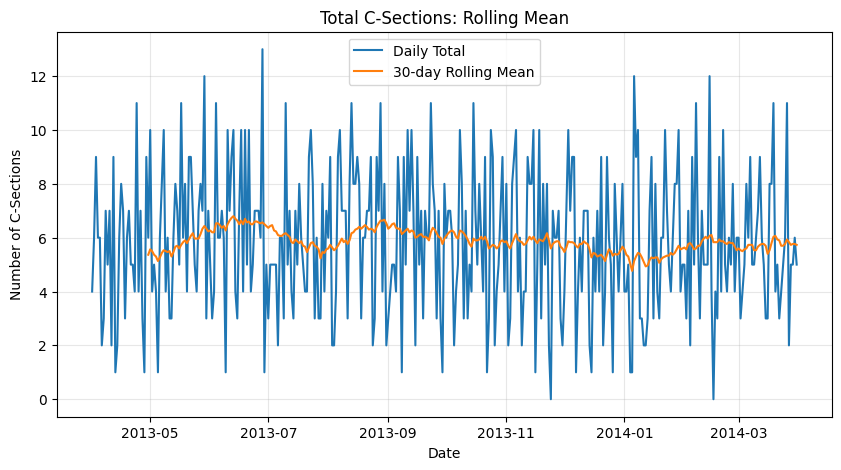

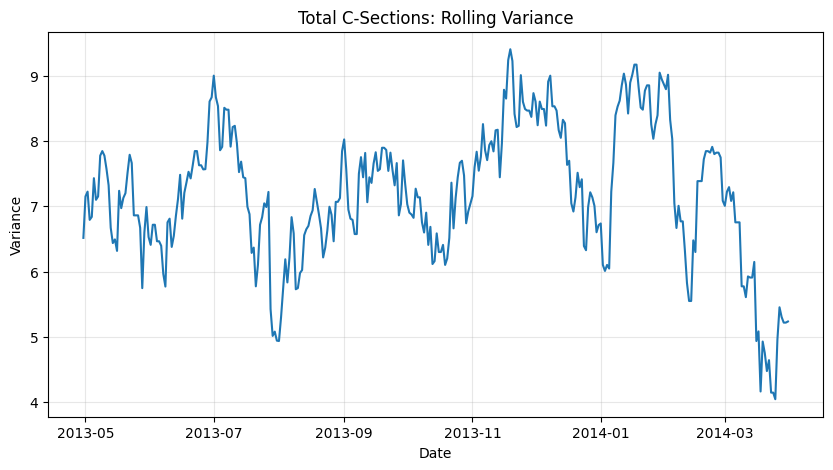

In [12]:
WINDOW = 30

# Rolling mean
roll_mean_total = ts_overall.rolling(WINDOW).mean()

plt.figure(figsize=(10,5))
plt.plot(ts_overall.index, ts_overall.values, label="Daily Total")
plt.plot(roll_mean_total.index, roll_mean_total.values,
         label=f"{WINDOW}-day Rolling Mean")

plt.title("Total C-Sections: Rolling Mean")
plt.xlabel("Date")
plt.ylabel("Number of C-Sections")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Rolling variance
roll_var_total = ts_overall.rolling(WINDOW).var()

plt.figure(figsize=(10,5))
plt.plot(roll_var_total.index, roll_var_total.values)
plt.title("Total C-Sections: Rolling Variance")
plt.xlabel("Date")
plt.ylabel("Variance")
plt.grid(True, alpha=0.3)
plt.show()


/tmp/ipython-input-3791277101.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pct_planned = pct_planned.fillna(0)
/tmp/ipython-input-3791277101.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pct_unplanned = pct_unplanned.fillna(0)


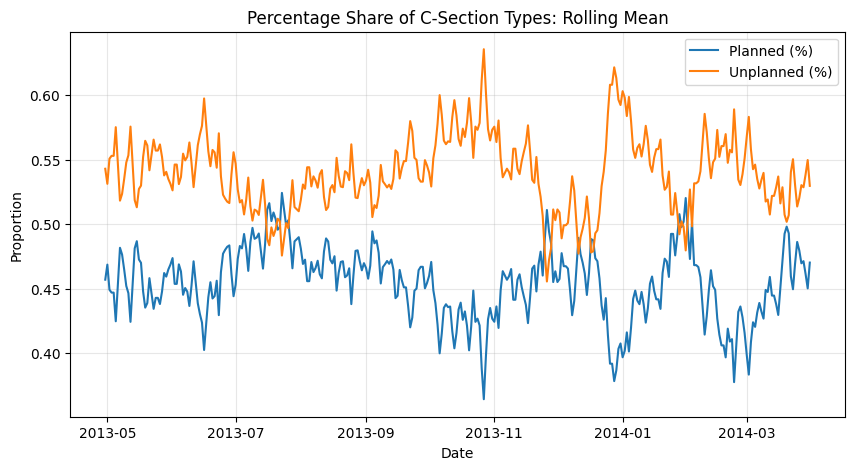

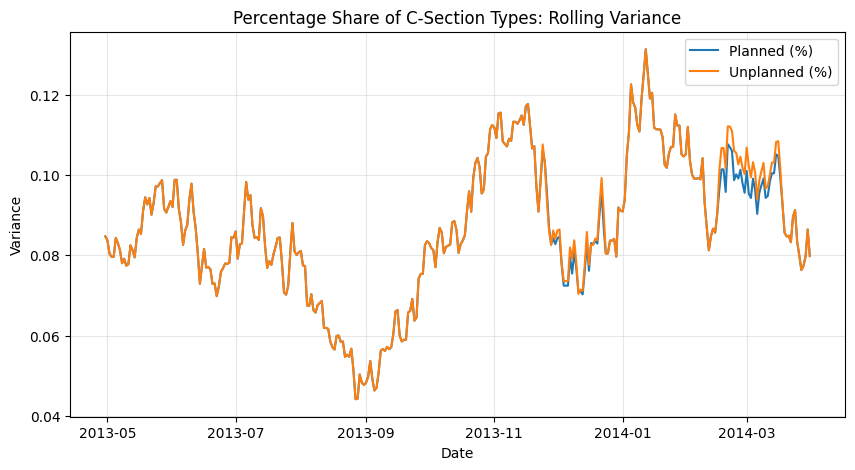

In [13]:
# Daily percentage share
pct_planned = ts_planned / ts_overall.replace(0, pd.NA)
pct_unplanned = ts_unplanned / ts_overall.replace(0, pd.NA)

pct_planned = pct_planned.fillna(0)
pct_unplanned = pct_unplanned.fillna(0)

# Rolling mean
roll_mean_pct_planned = pct_planned.rolling(WINDOW).mean()
roll_mean_pct_unplanned = pct_unplanned.rolling(WINDOW).mean()

plt.figure(figsize=(10,5))
plt.plot(roll_mean_pct_planned.index, roll_mean_pct_planned.values, label="Planned (%)")
plt.plot(roll_mean_pct_unplanned.index, roll_mean_pct_unplanned.values, label="Unplanned (%)")

plt.title("Percentage Share of C-Section Types: Rolling Mean")
plt.xlabel("Date")
plt.ylabel("Proportion")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Rolling variance
roll_var_pct_planned = pct_planned.rolling(WINDOW).var()
roll_var_pct_unplanned = pct_unplanned.rolling(WINDOW).var()

plt.figure(figsize=(10,5))
plt.plot(roll_var_pct_planned.index, roll_var_pct_planned.values, label="Planned (%)")
plt.plot(roll_var_pct_unplanned.index, roll_var_pct_unplanned.values, label="Unplanned (%)")

plt.title("Percentage Share of C-Section Types: Rolling Variance")
plt.xlabel("Date")
plt.ylabel("Variance")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


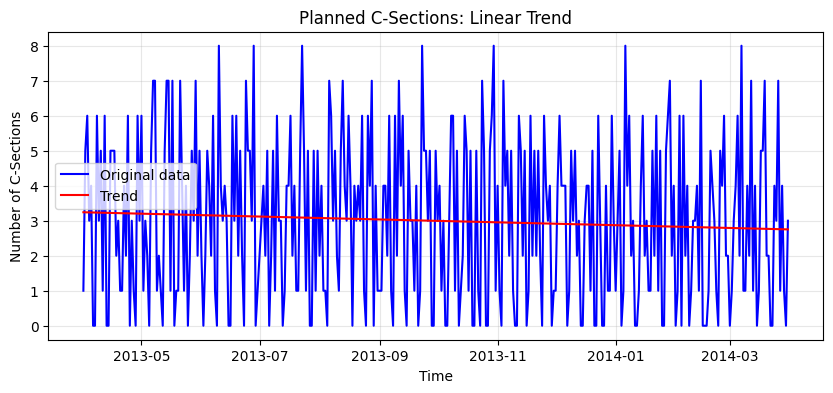

In [18]:
# Time index for regression
t = np.arange(len(ts_planned))

# Fit linear trend
coef = np.polyfit(t, ts_planned.values, 1)
trend_planned = coef[0] * t + coef[1]

plt.figure(figsize=(10,4))
plt.plot(ts_planned.index, ts_planned.values, color="blue", label="Original data")
plt.plot(ts_planned.index, trend_planned, color="red", label="Trend")

plt.title("Planned C-Sections: Linear Trend")
plt.xlabel("Time")
plt.ylabel("Number of C-Sections")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

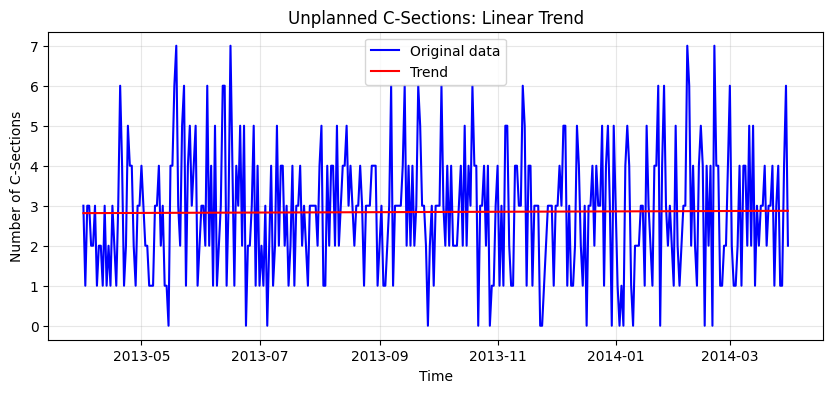

In [19]:
t = np.arange(len(ts_unplanned))

coef = np.polyfit(t, ts_unplanned.values, 1)
trend_unplanned = coef[0] * t + coef[1]

plt.figure(figsize=(10,4))
plt.plot(ts_unplanned.index, ts_unplanned.values, color="blue", label="Original data")
plt.plot(ts_unplanned.index, trend_unplanned, color="red", label="Trend")

plt.title("Unplanned C-Sections: Linear Trend")
plt.xlabel("Time")
plt.ylabel("Number of C-Sections")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
